#### Data Validation
This data contains 6738 rows, 9 columns. The following description of the data was given me:
- **model**: Character, the model of the car, 18 possible values.
- **year**: Numeric, year of registration from 1998 to 2020.
- **price**: Numeric, listed value of the car in GBP.
- **transmission**: Character, one of "Manual", "Automatic", "Semi-Auto" or "Other".
- **mileage**: Numeric, listed mileage of the car at time of sale.
- **fuelType**: Character, one of "Petrol", "Hybrid", "Diesel" or "Other".
- **tax**: Numeric, road tax in GBP. Calculated based on CO2 emissions or a fixed price depending on the age of the car.
- **mpg**: Numeric, miles per gallon as reported by manufacturer.
- **engineSize**: Numeric, listed engine size, one of 16 possible values.


I have made a minor adjust in **model**, striping white spaces from the category. All other columns where checked.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('Data/toyota.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [3]:
#Check for model 18 possible values
print(data['model'].nunique())
print(data['model'].unique())
data['model'] = data['model'].str.strip(' ') #Clean model column for white spaces

18
[' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser']


In [4]:
#Check for data range from 1998 to 2020
print(np.sort(data['year'].unique()))

[1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [5]:
#Check for transmission values
print(data['transmission'].unique())

['Manual' 'Automatic' 'Semi-Auto' 'Other']


In [6]:
#Check for fuelType values
print(data['fuelType'].unique())

['Petrol' 'Other' 'Hybrid' 'Diesel']


In [7]:
#Check for engineSize 16 possible values
print(data['engineSize'].nunique())
print(data['engineSize'].unique())

16
[2.  1.8 1.2 1.6 1.4 2.5 2.2 1.5 1.  1.3 0.  2.4 3.  2.8 4.2 4.5]


In [8]:
#Check for negative values in data
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


#### Exploratory Analysis
I have explored the target variable and features of the car, and the relationship between target variable and features. After the analysis, I decided to apply the following transformations:
- Price: Use log transformation

As shown in the left graphic, the target variable price has a right skew shape. To reduce the variance, I have applied a logarithm transformation to it.

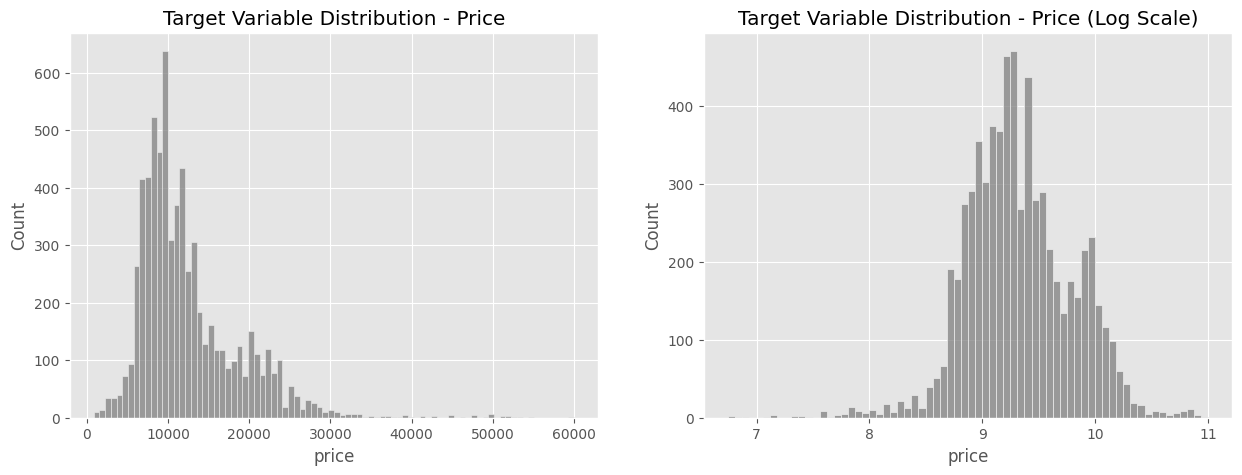

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data['price'], color='gray', ax=axes[0]).set(title='Target Variable Distribution - Price')
sns.histplot(np.log(data['price']), color='gray', ax=axes[1]).set(title='Target Variable Distribution - Price (Log Scale)')
plt.show()

##### Exploring the numerical variables
- The vehicle engineSize and year have the strongests correlation with the target variable. 
- The most expensive cars are newest cars with big engines.

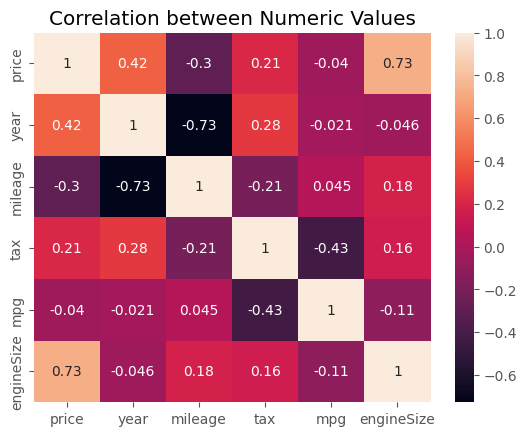

In [10]:
numerical_data = data.select_dtypes(include=['int', 'float'])
cols = numerical_data.columns.tolist()
cols.remove('price')
cols.insert(0, 'price')
numerical_data = numerical_data[cols]

sns.heatmap(numerical_data.corr(), annot=True).set(title='Correlation between Numeric Values')
plt.show()

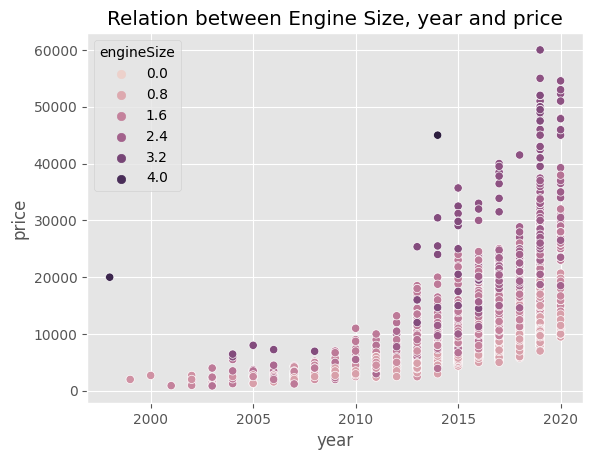

In [11]:
sns.scatterplot(data=numerical_data, x='year', y='price', hue='engineSize').set(title='Relation between Engine Size, year and price')
plt.show()

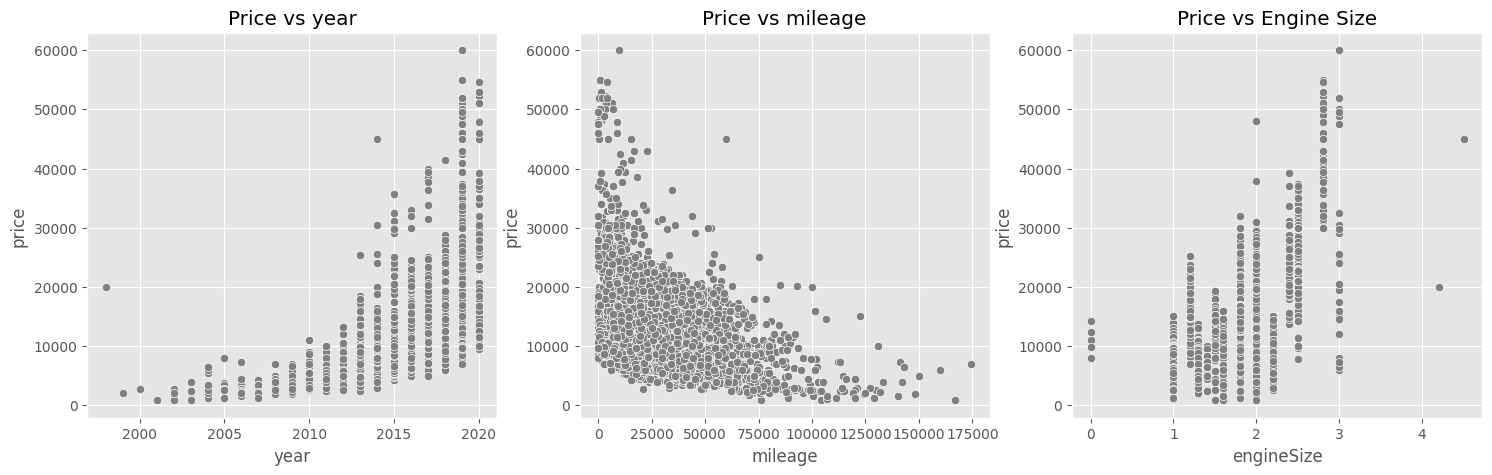

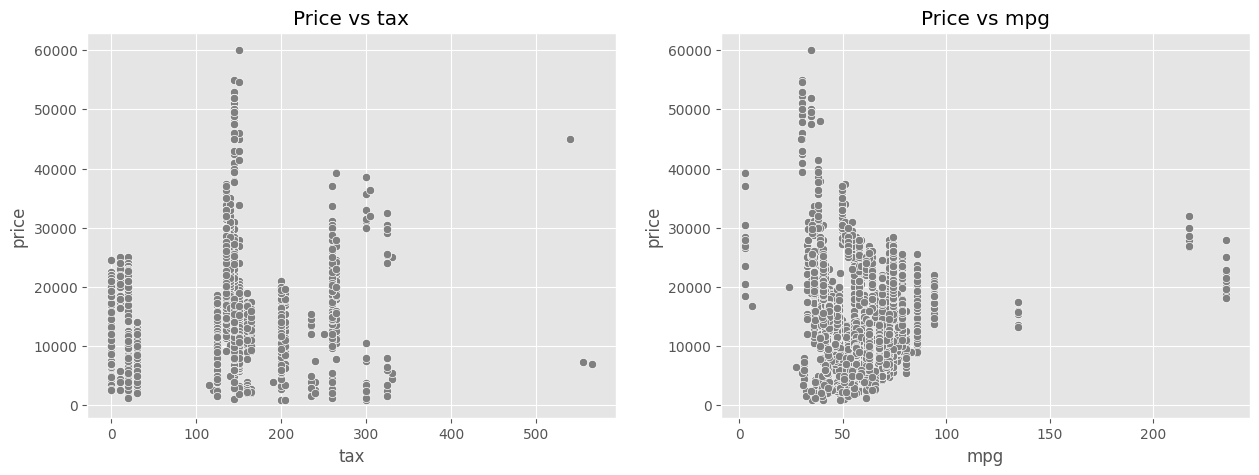

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=numerical_data, y='price', x='year', color='gray', ax=axes[0]).set(title='Price vs year')
sns.scatterplot(data=numerical_data, y='price', x='mileage', color='gray', ax=axes[1]).set(title='Price vs mileage')
sns.scatterplot(data=numerical_data, y='price', x='engineSize', color='gray', ax=axes[2]).set(title='Price vs Engine Size')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=numerical_data, y='price', x='tax', color='gray', ax=axes[0]).set(title='Price vs tax')
sns.scatterplot(data=numerical_data, y='price', x='mpg', color='gray', ax=axes[1]).set(title='Price vs mpg')
plt.show()

##### Exploring the categorical features
- The data have more models from **Yaris** and **Aygo**. For another version, it is recomended to gather more data from other models.
- We also have a fewer data of **Diesel** vehicles. 
- The distribution of price is different among each category in each variable.

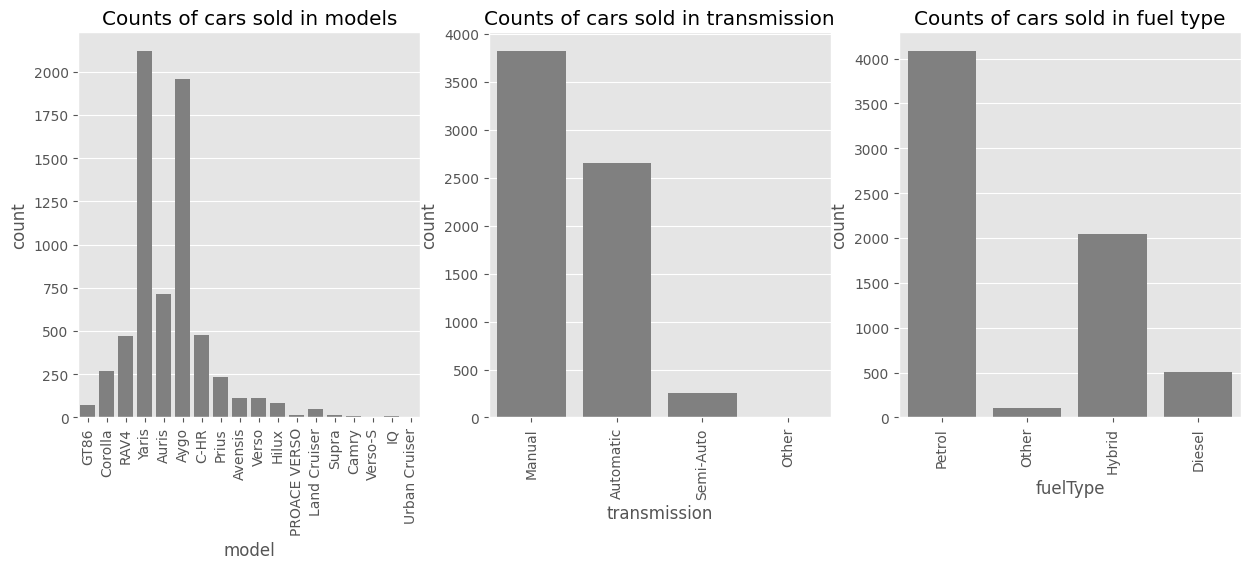

In [13]:
categorical_features = data.select_dtypes(include=['object'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data=categorical_features, x='model', ax=axes[0], color='gray').set(title='Counts of cars sold in models')
sns.countplot(data=categorical_features, x='transmission', ax=axes[1], color='gray').set(title='Counts of cars sold in transmission')
sns.countplot(data=categorical_features, x='fuelType', ax=axes[2], color='gray').set(title='Counts of cars sold in fuel type')
for ax in fig.axes:
    ax.tick_params(axis='x', rotation=90)
plt.show()

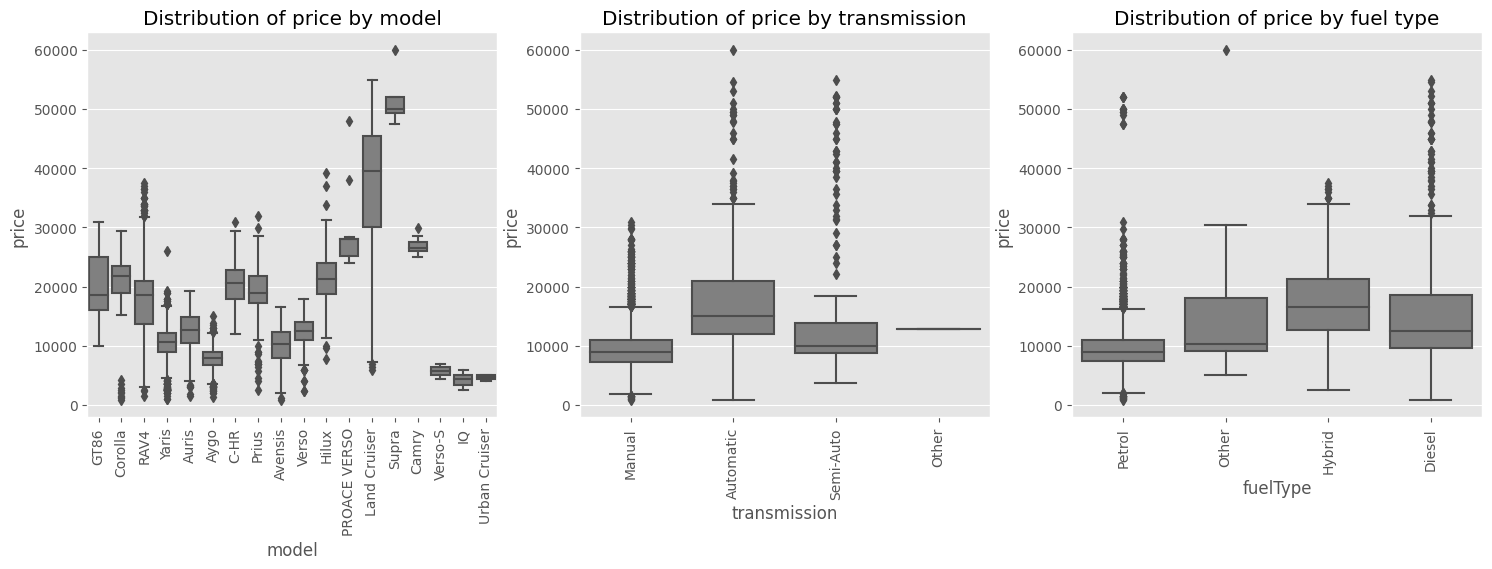

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(data=categorical_features, x='model', y=data['price'], ax=axes[0], color='gray').set(title='Distribution of price by model')
sns.boxplot(data=categorical_features, x='transmission', y=data['price'], ax=axes[1], color='gray').set(title='Distribution of price by transmission')
sns.boxplot(data=categorical_features, x='fuelType', y=data['price'], ax=axes[2], color='gray').set(title='Distribution of price by fuel type')
for ax in fig.axes:
    ax.tick_params(axis='x', rotation=90)
plt.show()

#### Model fit and evaluation
Since the target variable is continuous, we are facing a regression problem. We will first try a Linear Model as base and then, use some Tree model for non-linear patterns and comparison.
For the evaluation, we will use R Square metric to evaluate the model. R Squared measures how well the model fits dependent variables (i.e. features). After, I will use RMSE to measure how much the prediction deviate from the target variable.


##### Preparing data for modelling
To prepare the data for modelling, I made the following steps:
- Transform categorical features to numerical.
- Normalize numerical features.
- Split the data into train set and a test set.

In [15]:
data['price'] = np.log(data['price'])

In [16]:
X = data.drop(columns='price')
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

In [17]:
numerical_cols = numerical_data.loc[:, numerical_data.columns != 'price'].columns
categorical_cols = categorical_features.columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_lr = np.exp(pipeline.predict(X_test))
mse = mean_squared_error(np.exp(y_test), y_lr)
rmse_lr = mse**(1/2)
print('Linear Regression R-squared: ', pipeline.score(X_test, y_test))
print('Linear Regression RMSE: ', rmse_lr)

Linear Regression R-squared:  0.9514700409563571
Linear Regression RMSE:  1285.9632694668155


C:\Users\julio\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\julio\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


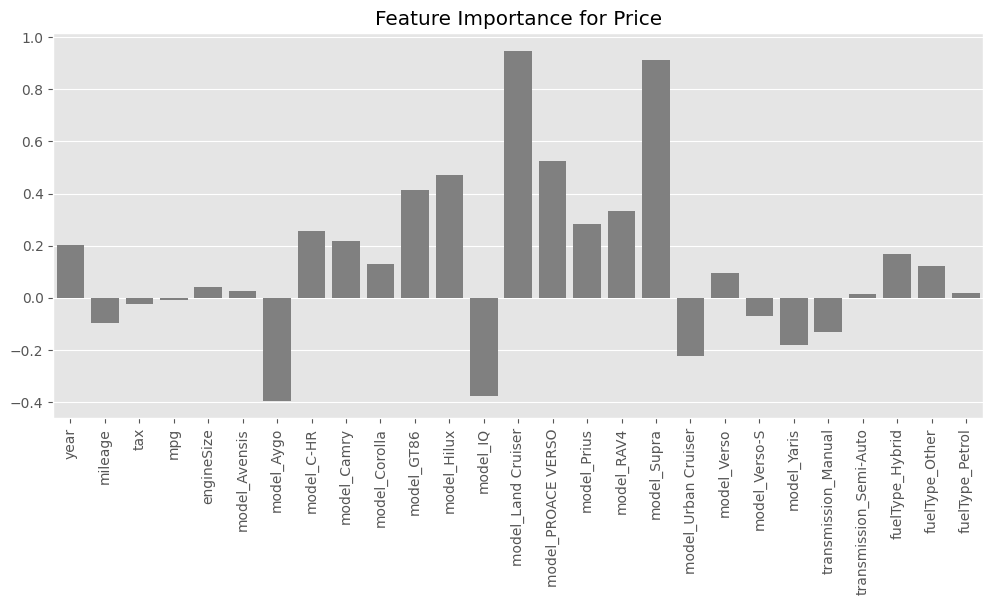

In [18]:
onehot_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, onehot_feature_names])
feature_importance = {
    'Feature': feature_names,
    'Importance':pipeline.named_steps['regressor'].coef_
}
plt.figure(figsize=(12, 5))
sns.barplot(x=feature_importance['Feature'], y=feature_importance['Importance'], color='gray').set(title='Feature Importance for Price')
plt.xticks(rotation=90)
plt.show()

In [19]:
param_grid = {
    'max_depth': np.arange(1, 13, 1)
}
model = GridSearchCV(RandomForestRegressor(random_state=1, min_samples_split=2), param_grid, scoring='r2', cv=3)

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

pipeline.fit(X_train, y_train)
y_tree = np.exp(pipeline.predict(X_test))
mse = mean_squared_error(np.exp(y_test), y_tree)
rmse_lr = mse**(1/2)
print('Random Forest Regressor R-squared: ', pipeline.score(X_test, y_test))
print('Random Forest Regressor RMSE: ', rmse_lr)

Random Forest Regressor R-squared:  0.959172024163739
Random Forest Regressor RMSE:  1137.1093802396908


C:\Users\julio\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\julio\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


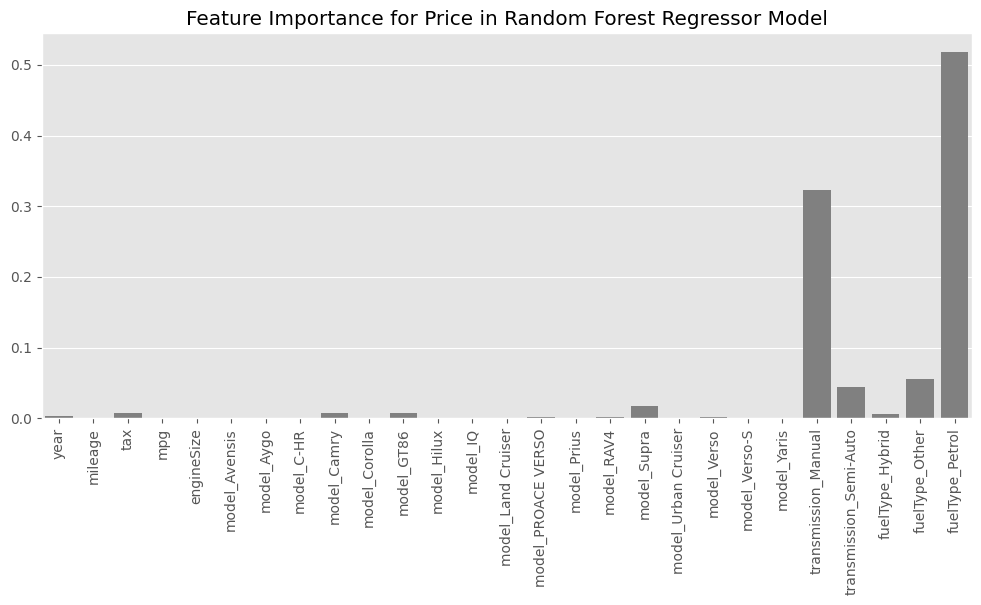

In [20]:
feature_importance = {
    'Feature': feature_names,
    'Importance':pipeline.named_steps['regressor'].best_estimator_.feature_importances_
}
plt.figure(figsize=(12, 5))
sns.barplot(x=feature_importance['Feature'], y=feature_importance['Importance'], color='gray').set(title='Feature Importance for Price in Random Forest Regressor Model')
plt.xticks(rotation=90)
plt.show()

##### Results
The R-squared value of both the Linear Regression and Random Forest Regressor is 0.95, indicating that both models explain the variance in the target variable equally well. However, the RMSE for Linear Regression is 1285 compared to 1137 for Random Forest, suggesting that Random Forest has a lower prediction error and performs better in predicting target values.

##### Evaluate by Business Criteria
The company wants to avoid prediction out of a range - within 10% of actual price. We can use the percentage of predictions within 10% of the actual price as a KPI. Higher the percentage, the better the model performs. 73% of Linear Regression Model predictions are within 10% range, against 79% for Random Forest Regressor model. This suggest that Random Forest Regressor model performs better.

In [21]:
diff_lr = (np.exp(y_test) - y_lr)/np.exp(y_test)
within_10pct = len([d for d in diff_lr if abs(d) <= 0.1])
pct_lr = within_10pct/len(diff_lr)
print(f'Percentage of predictions within +/- 10% range for Linear Model: {pct_lr}')

Percentage of predictions within +/- 10% range for Linear Model: 0.7309594460929772


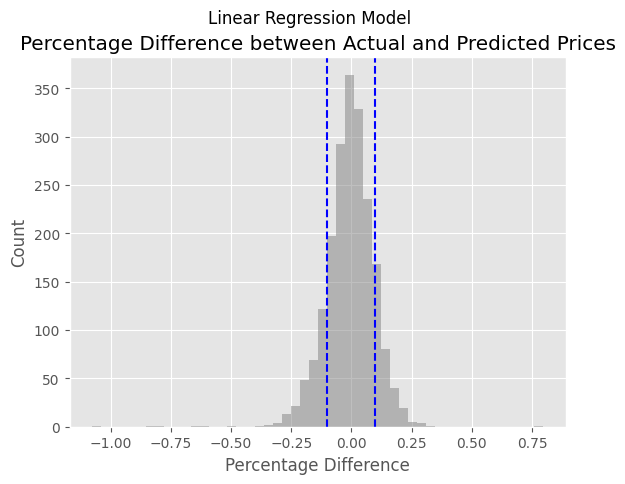

In [22]:
plt.hist(diff_lr, bins=50, color='gray', alpha=.5)
plt.axvline(x=0.1, color='b', linestyle='--', label='+/- 10% range')
plt.axvline(x=-0.1, color='b', linestyle='--')
plt.title('Percentage Difference between Actual and Predicted Prices')
plt.suptitle('Linear Regression Model')
plt.xlabel('Percentage Difference')
plt.ylabel('Count')
plt.show()

In [23]:
diff_tree = (np.exp(y_test) - y_tree)/np.exp(y_test)
within_10pct = len([d for d in diff_tree if abs(d) <= 0.1])
pct_tree = within_10pct/len(diff_tree)
print(f'Percentage of predictions within +/- 10% range for Random Forest Regressor: {pct_tree}')

Percentage of predictions within +/- 10% range for Random Forest Regressor: 0.7972304648862513


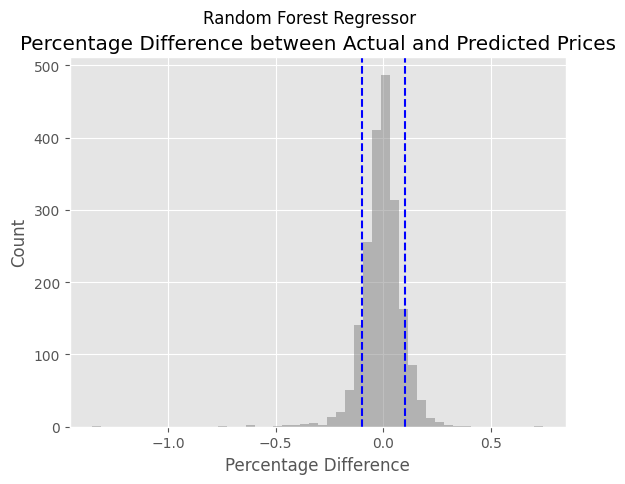

In [24]:
plt.hist(diff_tree, bins=50, color='gray', alpha=.5)
plt.axvline(x=0.1, color='b', linestyle='--', label='+/- 10% range')
plt.axvline(x=-0.1, color='b', linestyle='--')
plt.title('Percentage Difference between Actual and Predicted Prices')
plt.suptitle('Random Forest Regressor')
plt.xlabel('Percentage Difference')
plt.ylabel('Count')
plt.show()

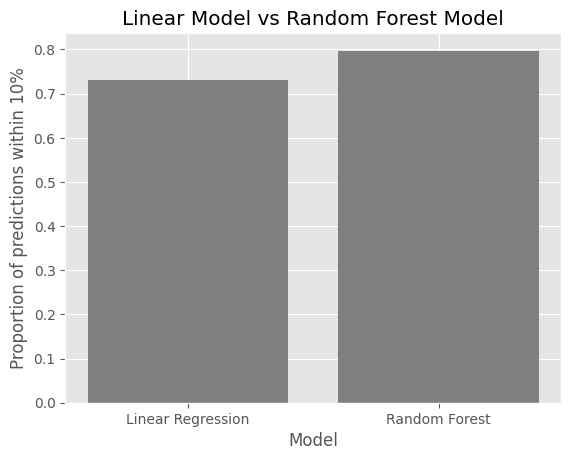

In [39]:
plt.bar(['Linear Regression', 'Random Forest'], height=[pct_lr, pct_tree], color='gray')
plt.title('Linear Model vs Random Forest Model')
plt.ylabel('Proportion of predictions within 10%')
plt.xlabel('Model')
plt.show()